In [2]:
import pandas as pd
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score

stopwords = nltk.corpus.stopwords.words('english')
lemmetizer = nltk.WordNetLemmatizer()

def remove_stop_words(text):
    text = [w for w in text if w.lower() not in stopwords]
    return text

def lemmetize_words(word_list):
    lemmetized = [lemmetizer.lemmatize(w) for w in word_list]
    return lemmetized

def remove_special_characters(text):
    text = [w for w in text if w.isalnum()]
    return text

def remove_non_english_words(text):
    printable = set(string.printable)
    return [word for word in text 
            if all(char in printable for char in word)]

def fix_text(row):
    return ' '.join(row)

df = pd.read_csv('IMDB Dataset.csv')
df['sentiment'] = df.sentiment.astype('category')
df = df.dropna()
df['final_text'] = df['review'].apply(nltk.word_tokenize)
df['final_text'] = df['final_text'].apply(remove_special_characters)
df['final_text'] = df['final_text'].apply(remove_non_english_words)
df['final_text'] = df['final_text'].apply(remove_stop_words)
df['final_text'] = df['final_text'].apply(lemmetize_words)
df['final_text'] = df['final_text'].apply(fix_text)

train_x, test_x, train_y, test_y = model_selection.train_test_split(df['final_text'], df['sentiment'], test_size=0.2)

In [3]:
tfidvect = TfidfVectorizer(max_features=5000)
tfidvect.fit(df['final_text'])
train_x_tfidf = tfidvect.transform(train_x)
test_x_tfidf = tfidvect.transform(test_x)

In [4]:
model = svm.SVC()
model.fit(train_x_tfidf, train_y)
pred = model.predict(test_x_tfidf)
accuracy_score(pred, test_y)

0.8873

<AxesSubplot:>

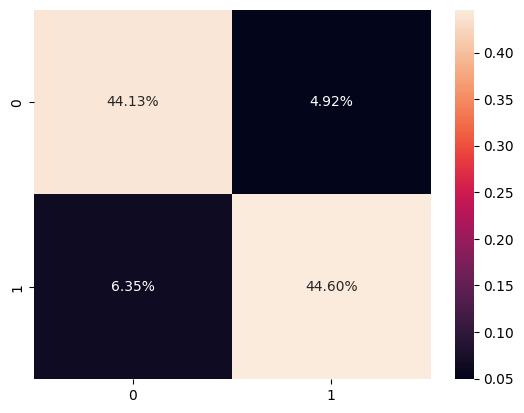

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cm = confusion_matrix(pred, test_y)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='0.2%')

In [8]:
import tweepy
import config
import re

consumer_key = config.api_key
consumer_secret = config.api_secrets
access_token = config.access_token
access_token_secret = config.access_secret
bearer_token = config.bearer_token

try:
    api = tweepy.Client(bearer_token=bearer_token)
except:
    print("Error: Authentication Failed")

def clean_text(text):
     return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])(\w+:\/\/\S+)", " ", text).split())   

tweets = tweepy.Paginator(api.search_recent_tweets , "Donald Trump", max_results = 100).flatten(limit=500)
    
def count(list):
    positive_count = 0
    negative_count = 0
    for line in list:
        if model.predict(tfidvect.transform([clean_text(line.text)])) == 'negative':
            negative_count += 1
        elif model.predict(tfidvect.transform([clean_text(line.text)])) == 'positive':
            positive_count += 1

    return positive_count, negative_count

count(tweets)
#comment change

(283, 217)